In [1]:
import mdtraj as md
import numpy as np
import pandas as pd
import sys
from scipy.spatial import ConvexHull

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

from natsort import natsorted
from pathlib import Path

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from funcs_featurise import *
from funcs_db_assign import *
from TrajData import *

plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 14  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label
plt.rcParams['axes.titlesize'] = 18   # Font size for title

In [2]:
dfg_spatial_colors = np.array([(89, 89, 89),         # Grey undefined
                               (238, 66, 102),       # Pink-red DFG-in
                               (255, 210, 63),       # Yellow DFG-inter
                               (84, 13, 110)])/255   # Purple DFG-out

### Abl1
---

In [3]:
protein = 'abl'
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data')
key = 'abl-pdb-50ps'

TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'),
               ftraj_dir= data_path / f'{protein}' / f'{key}' / 'ftrajs',
               dt=1,
               key=key)
TD.load_ftrajs(key=key,
               feature_names=['dbdist', 'hdbscan_dist_group'],)

dbdist, _ = TD.get_ftrajs(keys=key, 
                             dt_out=1, 
                             internal_names=['dbdist'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
distgroup, _ = TD.get_ftrajs(keys=key, 
                             dt_out=1, 
                             internal_names=['hdbscan_dist_group'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)

dbdist_cat = np.concatenate(dbdist, axis=0)
distgroup_cat = np.concatenate(distgroup, axis=0)

Setting dataset <abl-pdb-50ps>. 
Number of raw trajectories: 749

abl-pdb-50ps
Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 8753.74it/s]


Loading feature:  hdbscan_dist_group


100%|██████████| 749/749 [00:00<00:00, 11981.94it/s]


Stride for dataset abl-pdb-50ps with timestep 1 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 18502.90it/s]


Stride for dataset abl-pdb-50ps with timestep 1 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 34801.14it/s]


In [4]:
# Find the longest trajectory, one for each states
unique_clusters = np.delete(np.unique(distgroup_cat), 0)

longest_dbdist = []
for n in unique_clusters:
    # Find the indices of trajectories that belong to each state
    traj_n = []
    for i, traj in enumerate(distgroup):
        if traj.flatten()[0] == n:
            traj_n.append(i)

    # Find the longest trajectory
    max_len = 0
    max_traj = None
    for i in traj_n:
        if len(dbdist[i]) > max_len:
            max_len = len(dbdist[i])
            max_traj = i
    longest_dbdist.append(dbdist[max_traj])
    print(f'Cluster {n}: {max_len} frames. Id = {max_traj}')

Cluster 0: 38400 frames. Id = 476
Cluster 1: 40200 frames. Id = 485
Cluster 2: 41400 frames. Id = 662


In [15]:
TD.datasets['abl-pdb-50ps']['rtraj_files'][476]

PosixPath('/arc/abl_processed/run52-clone8.h5')

In [17]:
TD.datasets['abl-pdb-50ps']['rtraj_files']

[PosixPath('/arc/abl_processed/run0-clone0.h5'),
 PosixPath('/arc/abl_processed/run0-clone2.h5'),
 PosixPath('/arc/abl_processed/run0-clone3.h5'),
 PosixPath('/arc/abl_processed/run0-clone4.h5'),
 PosixPath('/arc/abl_processed/run0-clone5.h5'),
 PosixPath('/arc/abl_processed/run0-clone6.h5'),
 PosixPath('/arc/abl_processed/run0-clone7.h5'),
 PosixPath('/arc/abl_processed/run0-clone8.h5'),
 PosixPath('/arc/abl_processed/run0-clone9.h5'),
 PosixPath('/arc/abl_processed/run1-clone1.h5'),
 PosixPath('/arc/abl_processed/run1-clone2.h5'),
 PosixPath('/arc/abl_processed/run1-clone4.h5'),
 PosixPath('/arc/abl_processed/run1-clone5.h5'),
 PosixPath('/arc/abl_processed/run1-clone6.h5'),
 PosixPath('/arc/abl_processed/run1-clone7.h5'),
 PosixPath('/arc/abl_processed/run1-clone8.h5'),
 PosixPath('/arc/abl_processed/run1-clone9.h5'),
 PosixPath('/arc/abl_processed/run2-clone0.h5'),
 PosixPath('/arc/abl_processed/run2-clone1.h5'),
 PosixPath('/arc/abl_processed/run2-clone2.h5'),
 PosixPath('/arc/abl

In [8]:
protein = 'abl'
crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])

In [16]:
len(crystal_files)

83

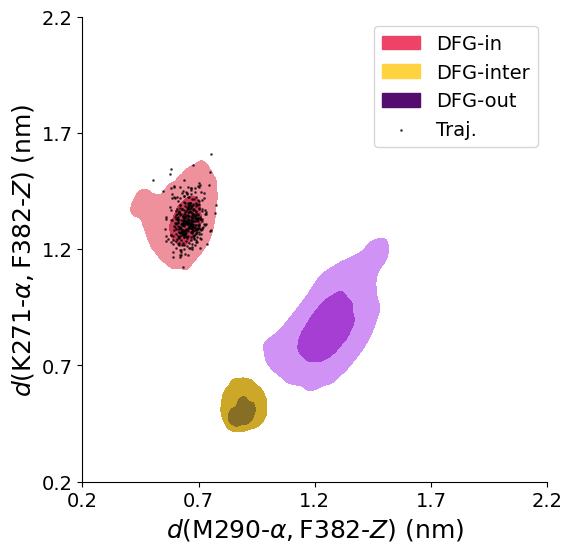

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

for cluster in unique_clusters:
    cluster_points = dbdist_cat[np.ravel(distgroup_cat) == cluster][::100, :]
    cluster_color = dfg_spatial_colors[cluster + 1] if cluster != -1 else dfg_spatial_colors[0]  # Map color
    
    sns.kdeplot(
        x=cluster_points[:, 0], 
        y=cluster_points[:, 1], 
        ax=ax, 
        fill=True, 
        color=cluster_color,
        alpha=1, 
        levels=3
    )

# Show the longest trajectory starting from DFG-in state as scatter
scatter = ax.scatter(longest_dbdist[0][::100, 0], 
                    longest_dbdist[0][::100, 1], 
                    color='black', 
                    s=1, alpha=0.6, label = 'Traj.')

# for longest_traj in longest_dbdist:
#     ax.scatter(longest_traj[::100, 0], 
#                longest_traj[::100, 1], 
#                color='black', 
#                s=1, alpha=0.6, label = 'Longest Trajectory')

legend_patches = [mpatches.Patch(color=dfg_spatial_colors[1], label = "DFG-in"),
                  mpatches.Patch(color=dfg_spatial_colors[2], label = "DFG-inter"),
                  mpatches.Patch(color=dfg_spatial_colors[3], label = "DFG-out"),
                  scatter]

ax.legend(handles=legend_patches, loc="upper right")
ax.set_xlabel(r"$d(\mathrm{M290}\text{-C\alpha}, \mathrm{F382}\text{-C}Z)$ (nm)")
ax.set_ylabel(r"$d(\mathrm{K271}\text{-C\alpha}, \mathrm{F382}\text{-C}Z)$ (nm)")
ax.set_xlim(0.2, 2.2)
ax.set_ylim(0.2, 2.2)
ax.set_xticks(np.arange(0.2, 2.21, 0.5))
ax.set_yticks(np.arange(0.2, 2.21, 0.5))
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('fig1c_abl_in.pdf', dpi=300, bbox_inches='tight')
plt.show()